In [64]:
%load_ext autoreload
%autoreload 2
from sys import path as syspath
from os import path as ospath
syspath.append(ospath.join(ospath.expanduser("~"), '/Users/mfanuel/Documents/Code/qiskit-nature'))

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from pfapack import pfaffian as pf


import qiskit as qk
from qiskit_nature.second_q.circuit.library import FermionicGaussianState
from qiskit import Aer
import utilities
import pandas as pd

# Import Aer and set the backend simulator
from qiskit import Aer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
N = 5
seed = 1
np.random.seed(seed)
# uniform orthogonal matrix
R, _ = np.linalg.qr(np.random.randn(2*N, 2*N))

One = np.eye(N)
Omega = (1/np.sqrt(2))*np.block([[One,One],[1j*One,-1j*One]])
W = np.dot(Omega.conj().T, np.dot(R,Omega))

occupied_orbitals = [0,1,2]

ind_plus = np.zeros(N)

for e in list(occupied_orbitals):
    ind_plus[e] = 1

ind_minus = 1 - ind_plus
ind = np.concatenate((ind_minus,ind_plus))
d_ind = np.diag(ind)

# construct S
S = np.dot(W.T,np.dot(d_ind, W.conj()))

# S = [I-K^T P^*\\
#      P       K]
# find the blocks

One = np.eye(N)
Z = np.zeros_like(One)

C = np.block([
    [Z, One],
    [One ,Z]
])

K = S[N:,N:]
P = S[N:,:N]

# a few tests
print(f"unitarity: | I - W^*  W | = {LA.norm(np.dot(W.conj().T ,W) - np.eye(2*N))}")
print(f"particle-hole on W: | W^T C W - C | = {LA.norm(np.dot(W.T,np.dot(C,W)) - C)}")
print(f"particle-hole on S: | C*S*C - I + S.conj | = {LA.norm(np.dot(C,np.dot(S,C)) - np.eye(2*N) + S.conj())}")

unitarity: | I - W^*  W | = 1.46362082187089e-15
particle-hole on W: | W^T C W - C | = 1.5412584731445848e-15
particle-hole on S: | C*S*C - I + S.conj | = 1.5888269803309108e-15


In [66]:
pfK = np.zeros((2*N,2*N), dtype=complex)
for i in range(N):
    for j in range(N):
        pfK[2*i -1,2*j-1] = P[i,j]
        pfK[2*i -1,2*j] = K[i,j]
        pfK[2*i,2*j-1] = -K[j,i]
        pfK[2*i,2*j] = -P[i,j].conj()
        
J = np.zeros((2*N,2*N), dtype=complex)
for i in range(N):
    J[2*i -1,2*i] = 1
    J[2*i,2*i-1] = -1

print(f"cond nb of pfK-J: = {LA.cond(pfK-J)}")
print(f"testing invertibility of pfK-J: | (pfK-J)*(pfK-J)^{-1} - I | = {LA.norm(np.eye(2*N) - np.dot(pfK-J,LA.inv(pfK-J)))}")

# Likelihood matrix
L = LA.inv(pfK-J) - J
L = 0.5*(L - L.T) 

cond nb of pfK-J: = 14.702625037717626
testing invertibility of pfK-J: | (pfK-J)*(pfK-J)^-1 - I | = 2.8959869454336697e-15


In [67]:
1. / pf.pfaffian(L + J).real

-0.0020686742186682935

In [68]:
# define matrix with 2-point function off-diag 
# and 1-point function diag
rho_2 = np.zeros_like(K.real)

for i in range(N):
    for j in range(N):
        if i == j:
            rho_2[i,i] = np.real(K[i,i])
        else:
            rho_2[i,j] = np.real(K[i,i] * K[j,j] - K[i,j] * K[i,j].conj() + P[i,j] * P[i,j].conj())

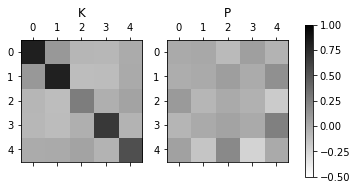

In [69]:
fig, ax = plt.subplots(1, 2)
vmin = -0.5
vmax = 1
cmap_str = "binary"

ax[0].matshow(K.real, cmap=cmap_str, vmin=vmin, vmax=vmax)
ax[0].set_title("K")

im = ax[1].matshow(P.real, cmap=cmap_str, vmin=vmin, vmax=vmax)
ax[1].set_title("P")
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.7)

plt.savefig('../fig/pfpp_K_P_proj.pdf', bbox_inches='tight')
plt.show()

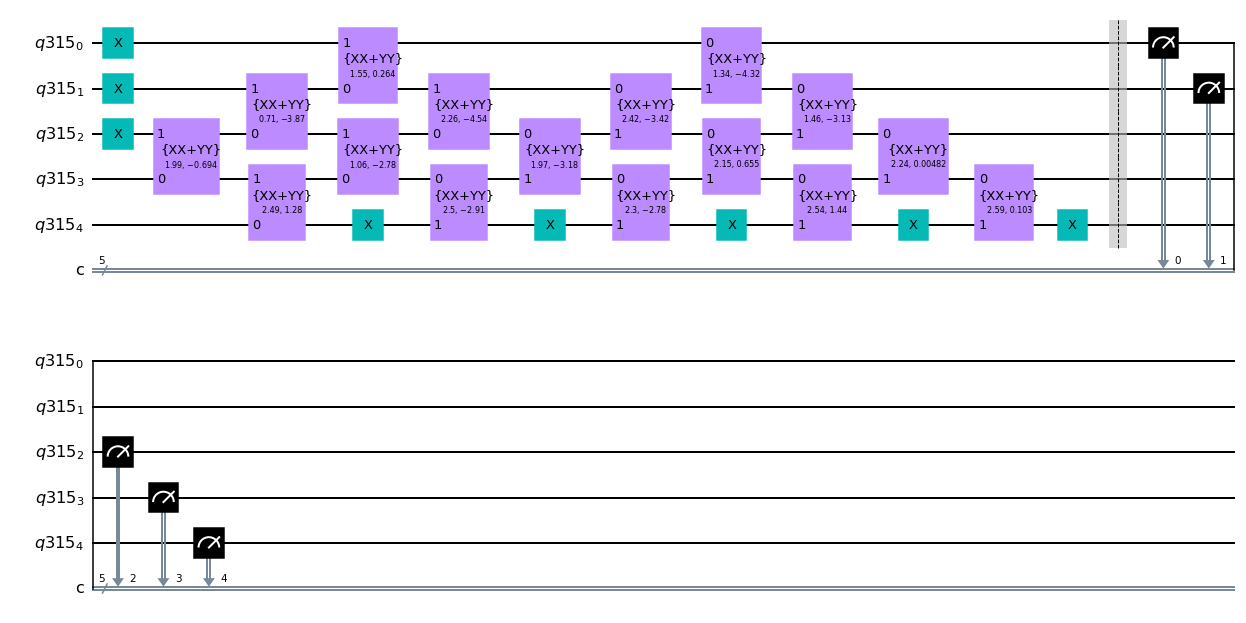

In [70]:
transformation_matrix = W[:N,:] # upper row
circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals=occupied_orbitals)
circuit.draw("mpl")

# Add measurements
meas = qk.QuantumCircuit(N, N) # N qubits, N classical bits
meas.barrier(range(N)) # the barrier is optional, it is an instruction for the later transpiler
meas.measure(range(N), range(N)) # perform the measurement, record it in the classical bits
circuit.add_register(meas.cregs[0])
qc = circuit.compose(meas)
# Draw the circuit
qc.draw(
    output="mpl", 
    #filename="../fig/example_circuit.pdf"
)

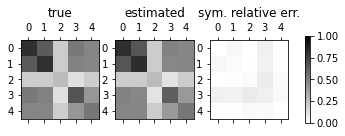

In [71]:
# Import Aer and set the backend simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
num_shots = 1000
job_sim = backend_sim.run(
    qk.transpile(qc, backend_sim), 
    shots=num_shots
)
# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

utilities.plot_results(counts,rho_2,num_shots)

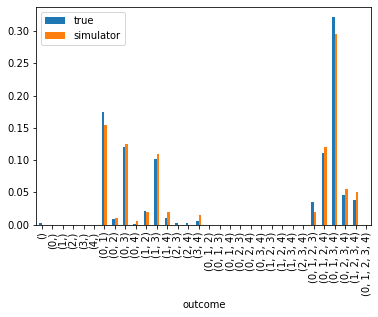

In [72]:
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator, we do several repeats to get 
# the distribution of the TV between the empirical measure and the underlying DPP.
tv_distances = []
num_repeats = 10
num_shots = 200
for _ in range(num_repeats):
    
    job_sim = backend_sim.run(
        qk.transpile(qc, backend_sim), 
        shots=num_shots
    )
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    proba, proba_estimated = utilities.get_estimated_probabilities_pfaffian(L,J, counts, num_shots, N)
    tv_distances.append(
        0.5*np.sum([np.abs(proba[key]-proba_estimated[key]) for key in proba])
    )
    
# Let us store the expected and estimated frequencies in a dataframe, 
# which we will complete later on with actual samples from IBMQ machines.
proba_series = pd.Series(proba.values(), index=list(proba.keys()), name="true")
proba_estimated_series = pd.Series(proba_estimated.values(), index=list(proba_estimated.keys()), name="simulator")
proba_series.index.name = "outcome"
proba_estimated_series.index.name = "outcome"
df = pd.merge(proba_series, proba_estimated_series, on="outcome")
#df.plot.bar()
fig = df.plot(kind='bar').get_figure()
fig.savefig("../fig/pfpp_random_results.pdf", bbox_inches = 'tight')